## Import some python packages

In [1]:
%matplotlib inline
import pickle
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
import random
import tensorflow.keras.utils
import tensorflow.keras.models as models
from tensorflow.keras.models import load_model  # For loading the trained model
from tensorflow.keras.layers import Reshape, Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import time

## Load the data

In [2]:
Xd = pickle.load(open("data/RML2016.10a_dict.pkl",'rb'),encoding = "bytes")
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

## Split the data into training and test sets

In [3]:
np.random.seed(2020)
n_examples = X.shape[0]
n_train = n_examples // 2

train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))

X_train = X[train_idx]
X_test = X[test_idx]

## Convert the dependent variables (labels) into one-hoe encoding format

In [4]:
lb = preprocessing.LabelBinarizer()
lb.fit(np.asarray(lbl)[:,0])
print(lb.classes_)

lbl_encoded = lb.transform(np.asarray(lbl)[:,0])
y_train = lbl_encoded[train_idx]
y_test = lbl_encoded[test_idx]

[b'8PSK' b'AM-DSB' b'AM-SSB' b'BPSK' b'CPFSK' b'GFSK' b'PAM4' b'QAM16'
 b'QAM64' b'QPSK' b'WBFM']


In [5]:
in_shp = list(X_train.shape[1:])
print(X_train.shape, in_shp)
classes = mods

(110000, 2, 128) [2, 128]


## Build all the PCA models used in this module

In [6]:
total_components = in_shp[0] * in_shp[1]

In [7]:
# PCA model that extracts 1/4 components, reduces the dimension by 75%
pca_1 = PCA(n_components = total_components // 4)

In [8]:
# PCA model that extracts 3/8 components, reduces the dimension by 62.5%
pca_2 = PCA(n_components = 3 * total_components // 8)

In [9]:
# PCA model that extracts 1/2 components, reduces the dimension by 50%
pca_3 = PCA(n_components = total_components // 2)

In [10]:
# PCA model that extracts 3/4 components, reduces the dimension by 25%
pca_4 = PCA(n_components = 3 * total_components // 4)

## Get all the low-dimensional inputs ready

In [11]:
# PCA model only accepts 2D or 1D data, the original data should be flatting from 3D to 2D first
X_train_flat = X_train.reshape((X_train.shape[0], -1))
X_test_flat = X_test.reshape((X_test.shape[0], -1))

In [12]:
X_train_1 = pca_1.fit_transform(X_train_flat)

In [13]:
X_train_2 = pca_2.fit_transform(X_train_flat)

In [14]:
X_train_3 = pca_3.fit_transform(X_train_flat)

In [15]:
X_train_4 = pca_4.fit_transform(X_train_flat)

In [16]:
X_test_1 = pca_1.fit_transform(X_test_flat)

In [17]:
X_test_2 = pca_2.fit_transform(X_test_flat)

In [18]:
X_test_3 = pca_3.fit_transform(X_test_flat)

In [19]:
X_test_4 = pca_4.fit_transform(X_test_flat)

## Restore the data to 3-dimension

In [20]:
X_train_1 = X_train_1.reshape(X_train_1.shape[0], 2, -1)
X_train_2 = X_train_2.reshape(X_train_2.shape[0], 2, -1)
X_train_3 = X_train_3.reshape(X_train_3.shape[0], 2, -1)
X_train_4 = X_train_4.reshape(X_train_4.shape[0], 2, -1)

In [21]:
X_test_1 = X_test_1.reshape(X_test_1.shape[0], 2, -1)
X_test_2 = X_test_2.reshape(X_test_2.shape[0], 2, -1)
X_test_3 = X_test_3.reshape(X_test_3.shape[0], 2, -1)
X_test_4 = X_test_4.reshape(X_test_4.shape[0], 2, -1)

## Get the `in_shp` variable ready for building the ANN models

In [22]:
in_shp_1 = list(X_train_1.shape[1:])
in_shp_2 = list(X_train_2.shape[1:])
in_shp_3 = list(X_train_3.shape[1:])
in_shp_4 = list(X_train_4.shape[1:])

## Load the ANN models used in this module

In [23]:
model_1 = load_model('model/ANN_model_1.h5')

In [24]:
model_2 = load_model('model/ANN_model_2.h5')

In [25]:
model_3 = load_model('model/ANN_model_3.h5')

In [26]:
model_4 = load_model('model/ANN_model_4.h5')

In [27]:
model_5 = load_model('model/ANN_model_5.h5')

## Build all the ANN models

#### If you have already loaded the model in the `Load the ANN models used in this module` section, please feel free to skip this step

In [28]:
def build_ANN_model(in_shp):
    model_ANN = models.Sequential()

    model_ANN.add(Dense(128, activation ='relu', input_shape = in_shp))

    model_ANN.add(Dense(256, activation ='relu'))

    model_ANN.add(Dense(128, activation = 'relu'))

    model_ANN.add(Flatten())

    model_ANN.add(Dense(128, activation = 'relu'))

    model_ANN.add(Dense(len(classes), activation = 'softmax'))
    
    return model_ANN

In [29]:
model_1 = build_ANN_model(in_shp_1)
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2, 128)            4224      
_________________________________________________________________
dense_1 (Dense)              (None, 2, 256)            33024     
_________________________________________________________________
dense_2 (Dense)              (None, 2, 128)            32896     
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 11)                1419      
Total params: 104,459
Trainable params: 104,459
Non-trainable params: 0
__________________________________________________

In [30]:
model_2 = build_ANN_model(in_shp_2)
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 2, 128)            6272      
_________________________________________________________________
dense_6 (Dense)              (None, 2, 256)            33024     
_________________________________________________________________
dense_7 (Dense)              (None, 2, 128)            32896     
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_9 (Dense)              (None, 11)                1419      
Total params: 106,507
Trainable params: 106,507
Non-trainable params: 0
________________________________________________

In [31]:
model_3 = build_ANN_model(in_shp_3)
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 2, 128)            8320      
_________________________________________________________________
dense_11 (Dense)             (None, 2, 256)            33024     
_________________________________________________________________
dense_12 (Dense)             (None, 2, 128)            32896     
_________________________________________________________________
flatten_2 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_14 (Dense)             (None, 11)                1419      
Total params: 108,555
Trainable params: 108,555
Non-trainable params: 0
________________________________________________

In [32]:
model_4 = build_ANN_model(in_shp_4)
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 2, 128)            12416     
_________________________________________________________________
dense_16 (Dense)             (None, 2, 256)            33024     
_________________________________________________________________
dense_17 (Dense)             (None, 2, 128)            32896     
_________________________________________________________________
flatten_3 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_19 (Dense)             (None, 11)                1419      
Total params: 112,651
Trainable params: 112,651
Non-trainable params: 0
________________________________________________

In [33]:
model_5 = build_ANN_model(in_shp)
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 2, 128)            16512     
_________________________________________________________________
dense_21 (Dense)             (None, 2, 256)            33024     
_________________________________________________________________
dense_22 (Dense)             (None, 2, 128)            32896     
_________________________________________________________________
flatten_4 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_24 (Dense)             (None, 11)                1419      
Total params: 116,747
Trainable params: 116,747
Non-trainable params: 0
________________________________________________

## Compile all the ANN models

#### If you have already loaded the model in the `Load the ANN models used in this module` section, please feel free to skip this step

In [34]:
model_1.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [35]:
model_2.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [36]:
model_3.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [37]:
model_4.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [38]:
model_5.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

## Train all the ANN models

#### If you have already loaded the model in the `Load the ANN models used in this module` section, please feel free to skip this step

In [39]:
tic_1 = time.time()
history_1 = model_1.fit(X_train_1, y_train, batch_size = 1024, epochs = 100, verbose = 1, 
                        validation_data = (X_test_1, y_test),
                        callbacks = [EarlyStopping(monitor = 'val_loss', patience = 10, 
                                                   verbose = 1, mode = 'auto', 
                                                   restore_best_weights = True)])
toc_1 = time.time()

Epoch 1/100
108/108 [==============================] - 10s 66ms/step - loss: 2.2819 - accuracy: 0.1631 - val_loss: 1.9707 - val_accuracy: 0.2477
Epoch 2/100
108/108 [==============================] - 3s 31ms/step - loss: 1.9183 - accuracy: 0.2788 - val_loss: 1.8767 - val_accuracy: 0.2881
Epoch 3/100
108/108 [==============================] - 4s 34ms/step - loss: 1.8151 - accuracy: 0.3177 - val_loss: 1.8613 - val_accuracy: 0.2971
Epoch 4/100
108/108 [==============================] - 3s 31ms/step - loss: 1.7721 - accuracy: 0.3335 - val_loss: 1.8510 - val_accuracy: 0.3040
Epoch 5/100
108/108 [==============================] - 3s 31ms/step - loss: 1.7518 - accuracy: 0.3429 - val_loss: 1.8451 - val_accuracy: 0.3063
Epoch 6/100
108/108 [==============================] - 3s 31ms/step - loss: 1.7217 - accuracy: 0.3517 - val_loss: 1.8381 - val_accuracy: 0.3076
Epoch 7/100
108/108 [==============================] - 3s 31ms/step - loss: 1.6976 - accuracy: 0.3602 - val_loss: 1.8380 - val_accuracy

In [40]:
tic_2 = time.time()
history_2 = model_2.fit(X_train_2, y_train, batch_size = 1024, epochs = 100, verbose = 1, 
                        validation_data = (X_test_2, y_test),
                        callbacks = [EarlyStopping(monitor = 'val_loss', patience = 10, 
                                                   verbose = 1, mode = 'auto', 
                                                   restore_best_weights = True)])
toc_2 = time.time()

Epoch 1/100
108/108 [==============================] - 5s 34ms/step - loss: 2.2886 - accuracy: 0.1614 - val_loss: 2.0097 - val_accuracy: 0.2359
Epoch 2/100
108/108 [==============================] - 3s 31ms/step - loss: 1.9443 - accuracy: 0.2654 - val_loss: 1.8960 - val_accuracy: 0.2840
Epoch 3/100
108/108 [==============================] - 3s 31ms/step - loss: 1.8285 - accuracy: 0.3138 - val_loss: 1.8822 - val_accuracy: 0.2913
Epoch 4/100
108/108 [==============================] - 3s 31ms/step - loss: 1.7978 - accuracy: 0.3245 - val_loss: 1.8989 - val_accuracy: 0.2806
Epoch 5/100
108/108 [==============================] - 3s 30ms/step - loss: 1.7712 - accuracy: 0.3349 - val_loss: 1.8654 - val_accuracy: 0.2959
Epoch 6/100
108/108 [==============================] - 3s 30ms/step - loss: 1.7460 - accuracy: 0.3420 - val_loss: 1.8669 - val_accuracy: 0.2922
Epoch 7/100
108/108 [==============================] - 3s 30ms/step - loss: 1.7253 - accuracy: 0.3507 - val_loss: 1.8554 - val_accuracy:

In [41]:
tic_3 = time.time()
history_3 = model_3.fit(X_train_3, y_train, batch_size = 1024, epochs = 100, verbose = 1, 
                        validation_data = (X_test_3, y_test),
                        callbacks = [EarlyStopping(monitor = 'val_loss', patience = 10, 
                                                   verbose = 1, mode = 'auto', 
                                                   restore_best_weights = True)])
toc_3 = time.time()

Epoch 1/100
108/108 [==============================] - 5s 35ms/step - loss: 2.2960 - accuracy: 0.1561 - val_loss: 2.0264 - val_accuracy: 0.2370
Epoch 2/100
108/108 [==============================] - 3s 30ms/step - loss: 1.9780 - accuracy: 0.2542 - val_loss: 1.9096 - val_accuracy: 0.2814
Epoch 3/100
108/108 [==============================] - 3s 31ms/step - loss: 1.8465 - accuracy: 0.3067 - val_loss: 1.9060 - val_accuracy: 0.2710
Epoch 4/100
108/108 [==============================] - 3s 31ms/step - loss: 1.8009 - accuracy: 0.3206 - val_loss: 1.9072 - val_accuracy: 0.2821
Epoch 5/100
108/108 [==============================] - 3s 31ms/step - loss: 1.7722 - accuracy: 0.3332 - val_loss: 1.8720 - val_accuracy: 0.2924
Epoch 6/100
108/108 [==============================] - 3s 32ms/step - loss: 1.7487 - accuracy: 0.3388 - val_loss: 1.8740 - val_accuracy: 0.2852
Epoch 7/100
108/108 [==============================] - 3s 31ms/step - loss: 1.7323 - accuracy: 0.3457 - val_loss: 1.8711 - val_accuracy:

In [42]:
tic_4 = time.time()
history_4 = model_4.fit(X_train_4, y_train, batch_size = 1024, epochs = 100, verbose = 1, 
                        validation_data = (X_test_4, y_test),
                        callbacks = [EarlyStopping(monitor = 'val_loss', patience = 10, 
                                                   verbose = 1, mode = 'auto', 
                                                   restore_best_weights = True)])
toc_4 = time.time()

Epoch 1/100
108/108 [==============================] - 5s 36ms/step - loss: 2.3140 - accuracy: 0.1585 - val_loss: 2.0216 - val_accuracy: 0.2368
Epoch 2/100
108/108 [==============================] - 3s 32ms/step - loss: 1.9697 - accuracy: 0.2535 - val_loss: 1.9216 - val_accuracy: 0.2765
Epoch 3/100
108/108 [==============================] - 3s 31ms/step - loss: 1.8478 - accuracy: 0.3071 - val_loss: 1.8948 - val_accuracy: 0.2824
Epoch 4/100
108/108 [==============================] - 3s 31ms/step - loss: 1.7979 - accuracy: 0.3251 - val_loss: 1.8769 - val_accuracy: 0.2924
Epoch 5/100
108/108 [==============================] - 3s 32ms/step - loss: 1.7549 - accuracy: 0.3429 - val_loss: 1.8693 - val_accuracy: 0.2925
Epoch 6/100
108/108 [==============================] - 3s 31ms/step - loss: 1.7293 - accuracy: 0.3476 - val_loss: 1.8755 - val_accuracy: 0.2986
Epoch 7/100
108/108 [==============================] - 3s 32ms/step - loss: 1.7000 - accuracy: 0.3621 - val_loss: 1.8654 - val_accuracy:

In [43]:
tic_5 = time.time()
history_5 = model_5.fit(X_train, y_train, batch_size = 1024, epochs = 100, verbose = 1, 
                        validation_data = (X_test, y_test),
                        callbacks = [EarlyStopping(monitor = 'val_loss', patience = 10, 
                                                   verbose = 1, mode = 'auto', 
                                                   restore_best_weights = True)])
toc_5 = time.time()

Epoch 1/100
108/108 [==============================] - 5s 36ms/step - loss: 2.2942 - accuracy: 0.1493 - val_loss: 2.0549 - val_accuracy: 0.2475
Epoch 2/100
108/108 [==============================] - 4s 33ms/step - loss: 1.9354 - accuracy: 0.2891 - val_loss: 1.8035 - val_accuracy: 0.3185
Epoch 3/100
108/108 [==============================] - 4s 33ms/step - loss: 1.7674 - accuracy: 0.3268 - val_loss: 1.7159 - val_accuracy: 0.3393
Epoch 4/100
108/108 [==============================] - 4s 33ms/step - loss: 1.6890 - accuracy: 0.3485 - val_loss: 1.6853 - val_accuracy: 0.3572
Epoch 5/100
108/108 [==============================] - 4s 33ms/step - loss: 1.6557 - accuracy: 0.3631 - val_loss: 1.6381 - val_accuracy: 0.3694
Epoch 6/100
108/108 [==============================] - 4s 33ms/step - loss: 1.6196 - accuracy: 0.3756 - val_loss: 1.6073 - val_accuracy: 0.3789
Epoch 7/100
108/108 [==============================] - 4s 33ms/step - loss: 1.5849 - accuracy: 0.3892 - val_loss: 1.5778 - val_accuracy:

## Save all the trained ANN models

#### If you have already loaded the model in the `Load the ANN models used in this module` section, please feel free to skip this step

In [44]:
model_1.save('model/ANN_model_1.h5')

In [45]:
model_2.save('model/ANN_model_2.h5')

In [46]:
model_3.save('model/ANN_model_3.h5')

In [47]:
model_4.save('model/ANN_model_4.h5')

In [48]:
model_5.save('model/ANN_model_5.h5')

## Compare the training time

#### If you have not trained the models, you may not get the reuslt in this section

In [49]:
training_time_1 = toc_1 - tic_1
training_time_2 = toc_2 - tic_2
training_time_3 = toc_3 - tic_3
training_time_4 = toc_4 - tic_4
training_time_5 = toc_5 - tic_5

print ("The training time for ANN with 75%% dimensionality reduction is %.3f seconds" %(training_time_1))
print ("The training time for ANN with 62.5%% dimensionality reduction is %.3f seconds" %(training_time_2))
print ("The training time for ANN with 50%% dimensionality reduction is %.3f seconds" %(training_time_3))
print ("The training time for ANN with 25%% dimensionality reduction is %.3f seconds" %(training_time_4))
print ("The training time for ANN without dimensionality reduction is %.3f seconds" %(training_time_5))

The training time for ANN with 75% dimensionality reduction is 77.844 seconds
The training time for ANN with 62.5% dimensionality reduction is 65.634 seconds
The training time for ANN with 50% dimensionality reduction is 58.939 seconds
The training time for ANN with 25% dimensionality reduction is 101.014 seconds
The training time for ANN without dimensionality reduction is 160.204 seconds


## Compare test loss and accuracy

In [50]:
score_1 = model_1.evaluate(X_test_1, y_test)

3438/3438 [==============================] - 6s 2ms/step - loss: 1.7883 - accuracy: 0.3331


In [51]:
score_2 = model_2.evaluate(X_test_2, y_test)

3438/3438 [==============================] - 6s 2ms/step - loss: 1.8439 - accuracy: 0.3123


In [52]:
score_3 = model_3.evaluate(X_test_3, y_test)

3438/3438 [==============================] - 6s 2ms/step - loss: 1.8711 - accuracy: 0.2889


In [53]:
score_4 = model_4.evaluate(X_test_4, y_test)

3438/3438 [==============================] - 6s 2ms/step - loss: 1.8397 - accuracy: 0.3244


In [54]:
score_5 = model_5.evaluate(X_test, y_test)

3438/3438 [==============================] - 6s 2ms/step - loss: 1.4509 - accuracy: 0.4491


In [55]:
print('Test loss of ANN with 75% dimensionality reduction:', score_1[0])
print('Test accuracy of ANN with 75% dimensionality reduction:', score_1[1])
print()
print('Test loss of ANN with 62.5% dimensionality reduction:', score_2[0])
print('Test accuracy of ANN with 62.5% dimensionality reduction:', score_2[1])
print()
print('Test loss of ANN with 50% dimensionality reduction:', score_3[0])
print('Test accuracy of ANN with 50% dimensionality reduction:', score_3[1])
print()
print('Test loss of ANN with 25% dimensionality reduction:', score_4[0])
print('Test accuracy of ANN with 25% dimensionality reduction:', score_4[1])
print()
print('Test loss of ANN without dimensionality reduction:', score_5[0])
print('Test accuracy of ANN without dimensionality reduction:', score_5[1])

Test loss of ANN with 75% dimensionality reduction: 1.788306713104248
Test accuracy of ANN with 75% dimensionality reduction: 0.3330909013748169

Test loss of ANN with 62.5% dimensionality reduction: 1.8439197540283203
Test accuracy of ANN with 62.5% dimensionality reduction: 0.31233635544776917

Test loss of ANN with 50% dimensionality reduction: 1.8710877895355225
Test accuracy of ANN with 50% dimensionality reduction: 0.28889089822769165

Test loss of ANN with 25% dimensionality reduction: 1.8396925926208496
Test accuracy of ANN with 25% dimensionality reduction: 0.3243545591831207

Test loss of ANN without dimensionality reduction: 1.4508939981460571
Test accuracy of ANN without dimensionality reduction: 0.4490545392036438


## Show classification report

In [80]:
y_predict_1 = model_1.predict(X_test_1)
print(classification_report(np.argmax(y_test, axis = 1), np.argmax(y_predict_1, axis = 1)))

              precision    recall  f1-score   support

           0       0.13      0.01      0.01      9991
           1       0.51      0.62      0.56     10041
           2       0.27      0.90      0.41      9915
           3       0.19      0.08      0.11      9841
           4       0.33      0.45      0.38     10076
           5       0.59      0.50      0.54     10067
           6       0.57      0.32      0.41     10086
           7       0.20      0.41      0.27     10024
           8       0.20      0.09      0.12      9920
           9       0.21      0.04      0.07      9998
          10       0.53      0.24      0.33     10041

    accuracy                           0.33    110000
   macro avg       0.34      0.33      0.29    110000
weighted avg       0.34      0.33      0.29    110000



In [81]:
y_predict_2 = model_2.predict(X_test_2)
print(classification_report(np.argmax(y_test, axis = 1), np.argmax(y_predict_2, axis = 1)))

              precision    recall  f1-score   support

           0       0.16      0.17      0.17      9991
           1       0.48      0.64      0.55     10041
           2       0.26      0.87      0.40      9915
           3       0.23      0.00      0.00      9841
           4       0.27      0.41      0.32     10076
           5       0.54      0.48      0.51     10067
           6       0.49      0.20      0.28     10086
           7       0.18      0.04      0.06     10024
           8       0.23      0.41      0.29      9920
           9       0.00      0.00      0.00      9998
          10       0.55      0.21      0.30     10041

    accuracy                           0.31    110000
   macro avg       0.31      0.31      0.26    110000
weighted avg       0.31      0.31      0.26    110000



In [82]:
y_predict_3 = model_3.predict(X_test_3)
print(classification_report(np.argmax(y_test, axis = 1), np.argmax(y_predict_3, axis = 1)))

              precision    recall  f1-score   support

           0       0.14      0.01      0.01      9991
           1       0.48      0.36      0.41     10041
           2       0.26      0.78      0.39      9915
           3       0.15      0.05      0.07      9841
           4       0.23      0.43      0.30     10076
           5       0.53      0.43      0.47     10067
           6       0.39      0.15      0.21     10086
           7       0.13      0.00      0.01     10024
           8       0.20      0.55      0.29      9920
           9       0.00      0.00      0.00      9998
          10       0.44      0.43      0.43     10041

    accuracy                           0.29    110000
   macro avg       0.27      0.29      0.24    110000
weighted avg       0.27      0.29      0.24    110000



In [83]:
y_predict_4 = model_4.predict(X_test_4)
print(classification_report(np.argmax(y_test, axis = 1), np.argmax(y_predict_4, axis = 1)))

              precision    recall  f1-score   support

           0       0.21      0.04      0.07      9991
           1       0.53      0.41      0.46     10041
           2       0.28      0.76      0.41      9915
           3       0.24      0.07      0.11      9841
           4       0.28      0.40      0.33     10076
           5       0.53      0.46      0.49     10067
           6       0.52      0.35      0.42     10086
           7       0.20      0.31      0.25     10024
           8       0.27      0.21      0.24      9920
           9       0.20      0.17      0.18      9998
          10       0.41      0.39      0.40     10041

    accuracy                           0.32    110000
   macro avg       0.33      0.32      0.31    110000
weighted avg       0.34      0.32      0.31    110000



In [84]:
y_predict_5 = model_5.predict(X_test)
print(classification_report(np.argmax(y_test, axis = 1), np.argmax(y_predict_5, axis = 1)))

              precision    recall  f1-score   support

           0       0.32      0.11      0.16      9991
           1       0.55      0.69      0.61     10041
           2       0.27      0.90      0.42      9915
           3       0.53      0.43      0.48      9841
           4       0.60      0.60      0.60     10076
           5       0.88      0.60      0.72     10067
           6       0.71      0.48      0.58     10086
           7       0.29      0.09      0.14     10024
           8       0.38      0.43      0.40      9920
           9       0.31      0.32      0.32      9998
          10       0.59      0.28      0.38     10041

    accuracy                           0.45    110000
   macro avg       0.49      0.45      0.44    110000
weighted avg       0.49      0.45      0.44    110000



## Show loss curves 

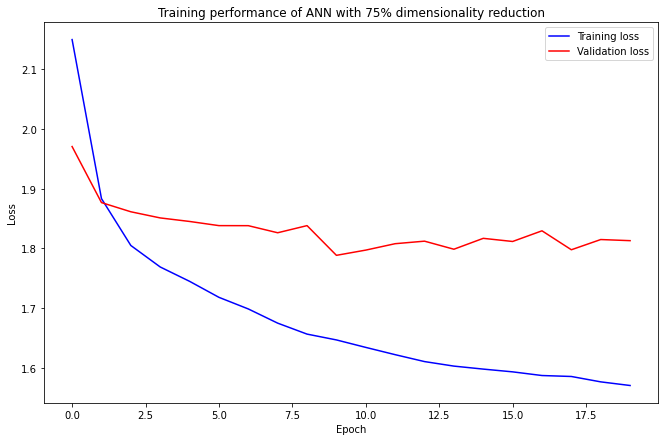

In [85]:
plt.figure(figsize = (11, 7))
plt.title('Training performance of ANN with 75% dimensionality reduction')
plt.plot(history_1.epoch, history_1.history['loss'], color = 'blue', label = 'Training loss')
plt.plot(history_1.epoch, history_1.history['val_loss'], color = 'red', label = 'Validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('img/ANN_loss_curve_1.png')
plt.show()

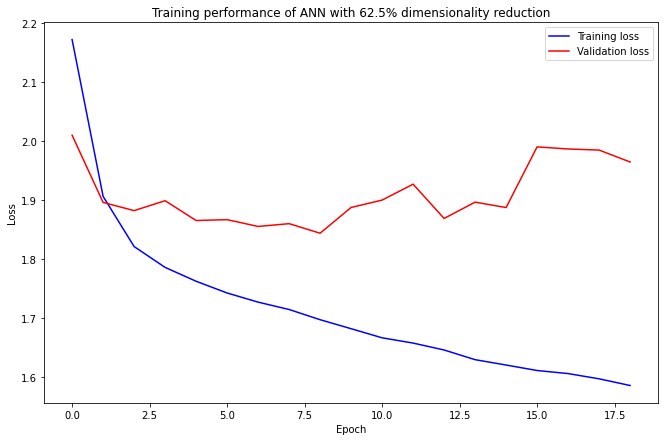

In [86]:
plt.figure(figsize = (11, 7))
plt.title('Training performance of ANN with 62.5% dimensionality reduction')
plt.plot(history_2.epoch, history_2.history['loss'], color = 'blue', label = 'Training loss')
plt.plot(history_2.epoch, history_2.history['val_loss'], color = 'red', label = 'Validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('img/ANN_loss_curve_2.png')
plt.show()

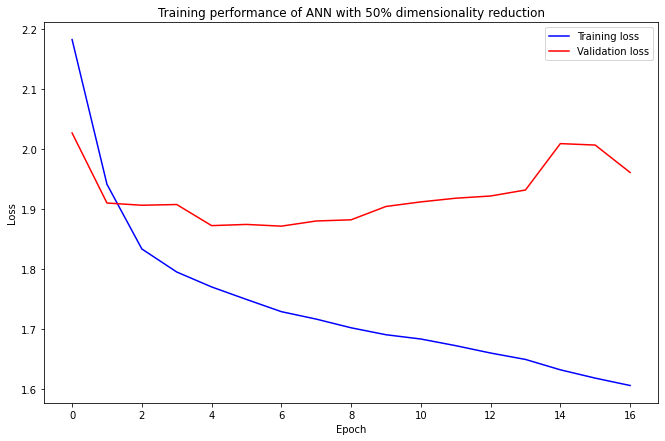

In [87]:
plt.figure(figsize = (11, 7))
plt.title('Training performance of ANN with 50% dimensionality reduction')
plt.plot(history_3.epoch, history_3.history['loss'], color = 'blue', label = 'Training loss')
plt.plot(history_3.epoch, history_3.history['val_loss'], color = 'red', label = 'Validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('img/ANN_loss_curve_3.png')
plt.show()

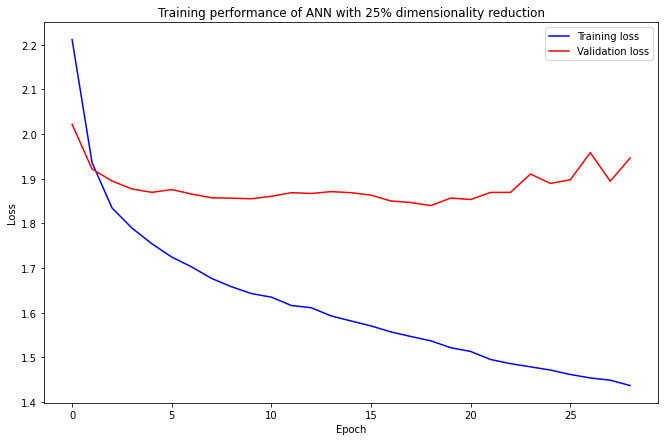

In [88]:
plt.figure(figsize = (11, 7))
plt.title('Training performance of ANN with 25% dimensionality reduction')
plt.plot(history_4.epoch, history_4.history['loss'], color = 'blue', label = 'Training loss')
plt.plot(history_4.epoch, history_4.history['val_loss'], color = 'red', label = 'Validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('img/ANN_loss_curve_4.png')
plt.show()

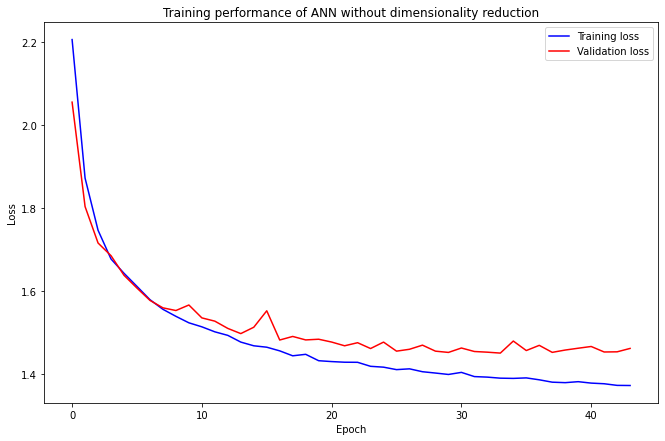

In [89]:
plt.figure(figsize = (11, 7))
plt.title('Training performance of ANN without dimensionality reduction')
plt.plot(history_5.epoch, history_5.history['loss'], color = 'blue', label = 'Training loss')
plt.plot(history_5.epoch, history_5.history['val_loss'], color = 'red', label = 'Validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('img/ANN_loss_curve_5.png')
plt.show()

## Plot confusion matrix

In [90]:
def plot_confusion_matrix(cm, title, cmap = plt.cm.Blues, labels = []):
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation = 45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [91]:
def confusion_matrix(model, classes, X_test, y_test, title):
    test_Y_hat = model.predict(X_test, batch_size = 1024)
    conf = np.zeros([len(classes), len(classes)])
    confnorm = np.zeros([len(classes), len(classes)])

    for i in range(0, X_test.shape[0]):
        j = list(y_test[i,:]).index(1)
        k = int(np.argmax(test_Y_hat[i,:]))
        conf[j,k] = conf[j,k] + 1

    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

    plot_confusion_matrix(confnorm, title, labels = classes)

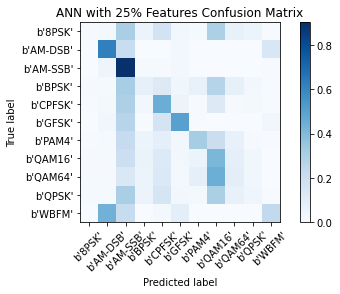

In [92]:
confusion_matrix(model_1, classes, X_test_1, y_test, 'ANN with 25% Features Confusion Matrix')

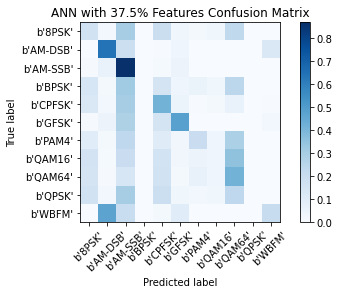

In [93]:
confusion_matrix(model_2, classes, X_test_2, y_test, 'ANN with 37.5% Features Confusion Matrix')

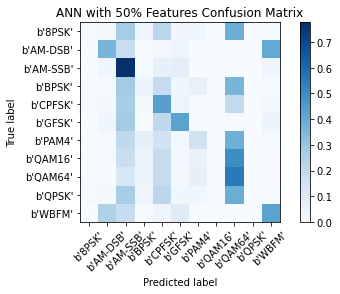

In [94]:
confusion_matrix(model_3, classes, X_test_3, y_test, 'ANN with 50% Features Confusion Matrix')

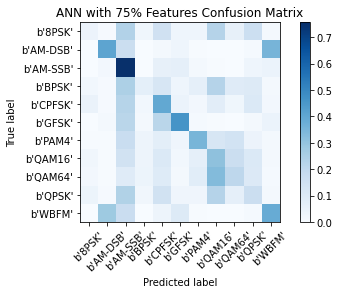

In [95]:
confusion_matrix(model_4, classes, X_test_4, y_test, 'ANN with 75% Features Confusion Matrix')

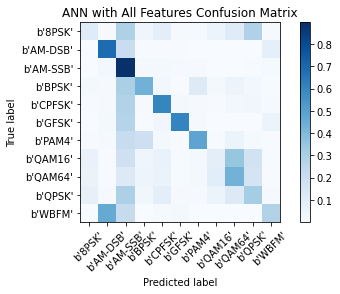

In [96]:
confusion_matrix(model_5, classes, X_test, y_test, 'ANN with All Features Confusion Matrix')

## Get the test accuracy for different SNRs

In [97]:
def getTestAccArray(model, lbl, X_test, y_test, test_idx, model_name):
    acc = []
    
    snr_array=np.asarray(lbl)[:,1]
    lb_temp = preprocessing.LabelBinarizer()
    lb_temp.fit(snr_array)
    temp_array=lb_temp.classes_
    snr_label_array = []
    test_SNRs=snr_array[test_idx]

    snr_label_array.append(temp_array[6])
    snr_label_array.append(temp_array[4])
    snr_label_array.append(temp_array[3])
    snr_label_array.append(temp_array[2])
    snr_label_array.append(temp_array[1])
    snr_label_array.append(temp_array[0])
    snr_label_array.append(temp_array[9])
    snr_label_array.append(temp_array[8])
    snr_label_array.append(temp_array[7])
    snr_label_array.append(temp_array[5])
    snr_label_array.append(temp_array[10])
    snr_label_array.append(temp_array[16])
    snr_label_array.append(temp_array[17])
    snr_label_array.append(temp_array[18])
    snr_label_array.append(temp_array[19])
    snr_label_array.append(temp_array[11])
    snr_label_array.append(temp_array[12])
    snr_label_array.append(temp_array[13])
    snr_label_array.append(temp_array[14])
    snr_label_array.append(temp_array[15])

    for snr in snr_label_array:
        test_X_i = X_test[np.where(test_SNRs==snr)]
        test_Y_i = y_test[np.where(test_SNRs==snr)]

        test_Y_i_hat = model.predict(test_X_i)
        conf = np.zeros([len(classes), len(classes)])
        confnorm = np.zeros([len(classes), len(classes)])
        
        for i in range(0, test_X_i.shape[0]):
            j = list(test_Y_i[i,:]).index(1)
            k = int(np.argmax(test_Y_i_hat[i,:]))
            conf[j,k] = conf[j,k] + 1
            
        for i in range(0, len(classes)):
            confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

        plt.figure()
        SNR_value = snr.astype('int')
        plot_confusion_matrix(confnorm, labels=classes, 
                              title="{model_name} Confusion Matrix \n (SNR={SNR_value})".format(model_name=model_name, SNR_value=SNR_value))

        cor = np.sum(np.diag(conf))
        ncor = np.sum(conf) - cor
        print("Overall Accuracy: ", cor / (cor+ncor),"for SNR",snr)
        acc.append(1.0*cor/(cor+ncor))
        
    return acc

Confusion matrix of ANN with 25% features for different SNRs
Overall Accuracy:  0.09267241379310345 for SNR b'-20'
Overall Accuracy:  0.09837561598831904 for SNR b'-18'
Overall Accuracy:  0.10205553552109628 for SNR b'-16'
Overall Accuracy:  0.10332845647403073 for SNR b'-14'
Overall Accuracy:  0.13369079535299375 for SNR b'-12'
Overall Accuracy:  0.18925878241677396 for SNR b'-10'
Overall Accuracy:  0.24611686390532544 for SNR b'-8'
Overall Accuracy:  0.3405810341677325 for SNR b'-6'
Overall Accuracy:  0.39870921477231985 for SNR b'-4'
Overall Accuracy:  0.4188453159041394 for SNR b'-2'
Overall Accuracy:  0.4252113193678795 for SNR b'0'
Overall Accuracy:  0.43686502177068215 for SNR b'2'
Overall Accuracy:  0.4516010978956999 for SNR b'4'
Overall Accuracy:  0.4597321592368373 for SNR b'6'
Overall Accuracy:  0.4550521395181589 for SNR b'8'
Overall Accuracy:  0.4684107492436377 for SNR b'10'
Overall Accuracy:  0.4600400509739669 for SNR b'12'
Overall Accuracy:  0.4680618744313012 for SNR

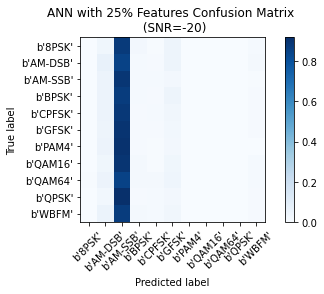

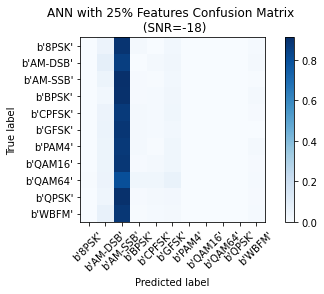

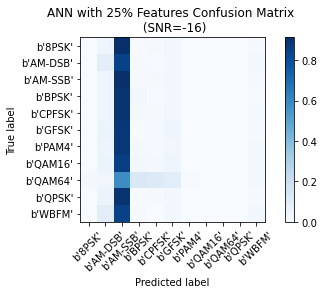

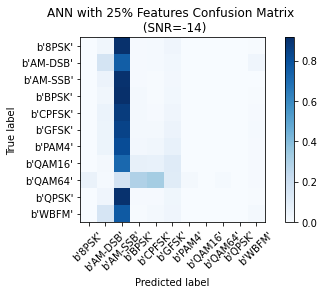

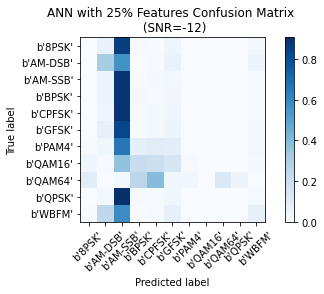

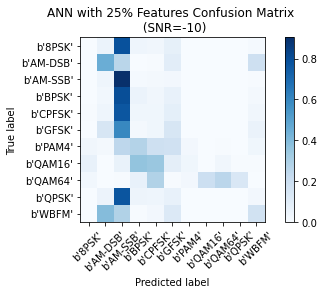

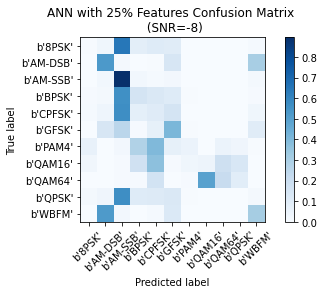

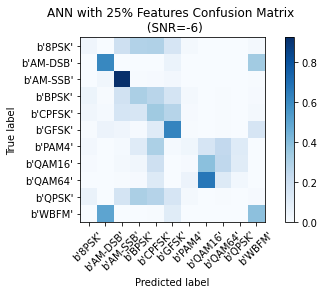

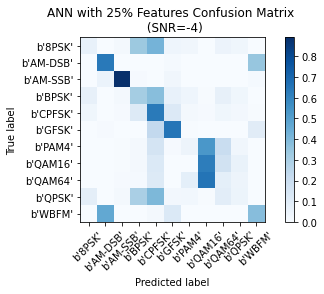

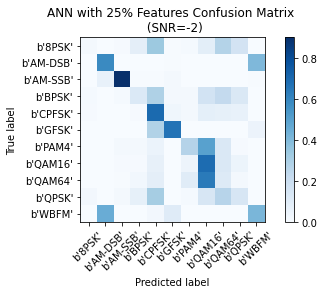

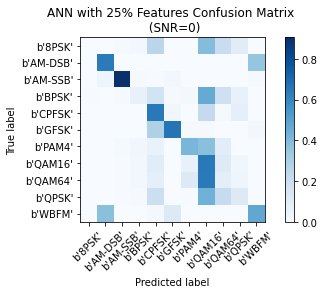

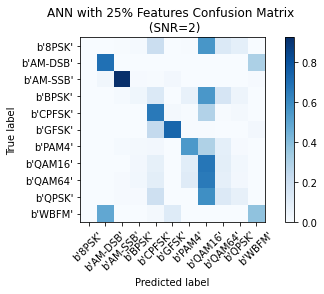

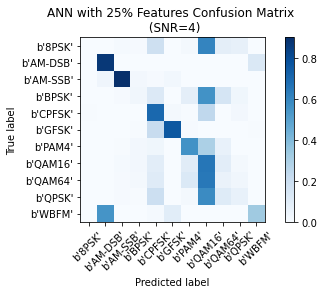

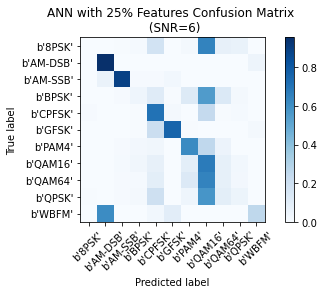

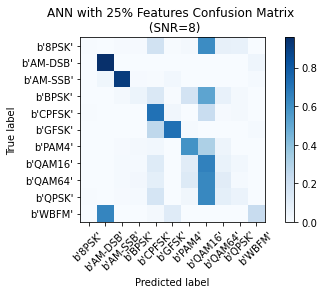

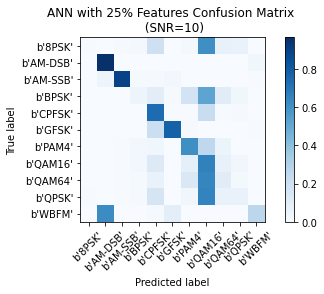

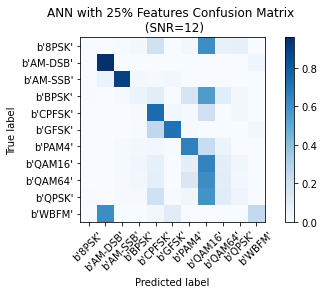

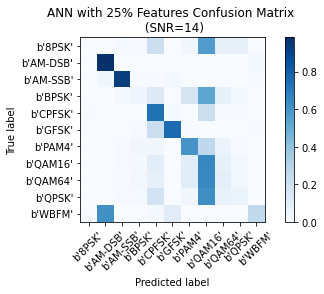

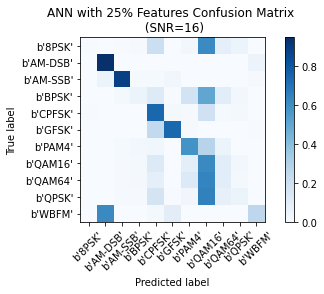

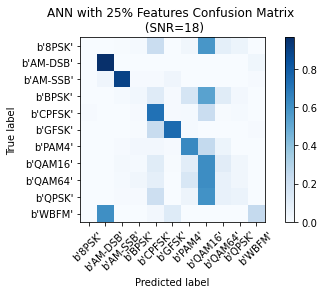

In [98]:
print('Confusion matrix of ANN with 25% features for different SNRs')
acc_1 = getTestAccArray(model_1, lbl, X_test_1, y_test, test_idx, 'ANN with 25% Features')

Confusion matrix of ANN with 37.5% features for different SNRs
Overall Accuracy:  0.09303160919540229 for SNR b'-20'
Overall Accuracy:  0.09874064610330352 for SNR b'-18'
Overall Accuracy:  0.09935088351965381 for SNR b'-16'
Overall Accuracy:  0.10680321872713973 for SNR b'-14'
Overall Accuracy:  0.12707774798927615 for SNR b'-12'
Overall Accuracy:  0.17877505977561156 for SNR b'-10'
Overall Accuracy:  0.20506656804733728 for SNR b'-8'
Overall Accuracy:  0.309884889457336 for SNR b'-6'
Overall Accuracy:  0.38526353531731805 for SNR b'-4'
Overall Accuracy:  0.41249092229484385 for SNR b'-2'
Overall Accuracy:  0.40922454979786843 for SNR b'0'
Overall Accuracy:  0.4350507982583454 for SNR b'2'
Overall Accuracy:  0.4133577310155535 for SNR b'4'
Overall Accuracy:  0.423958906622638 for SNR b'6'
Overall Accuracy:  0.4216109313196692 for SNR b'8'
Overall Accuracy:  0.43085958355579285 for SNR b'10'
Overall Accuracy:  0.4170762789004187 for SNR b'12'
Overall Accuracy:  0.42547770700636944 for 

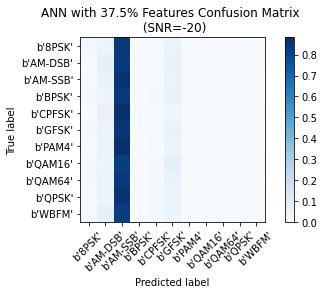

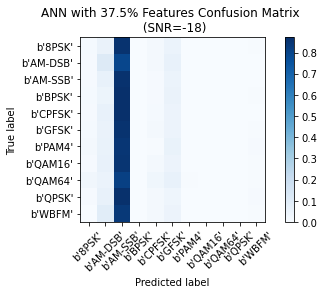

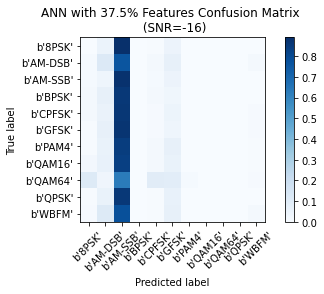

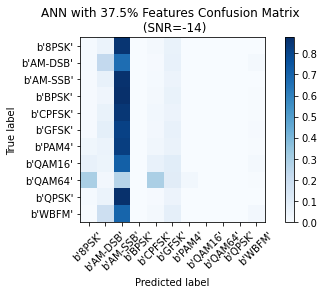

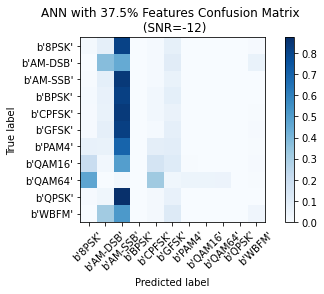

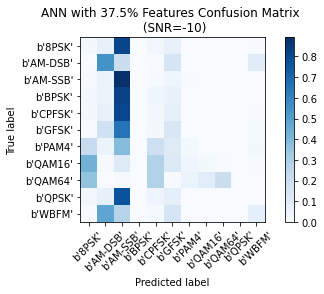

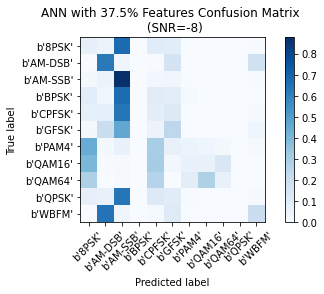

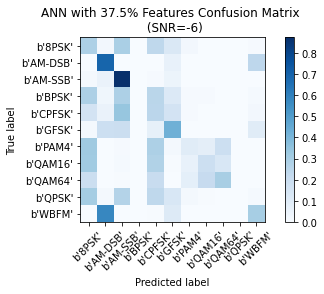

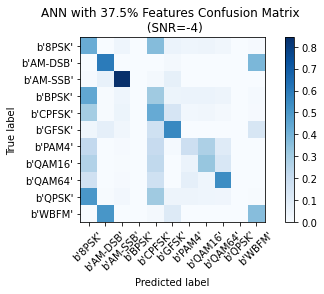

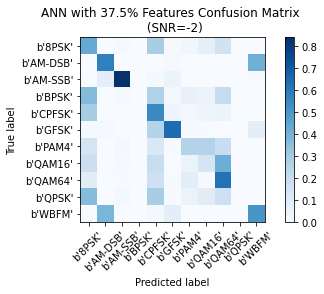

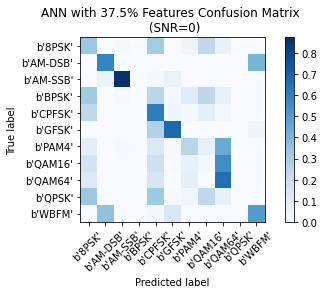

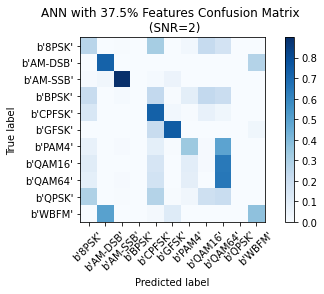

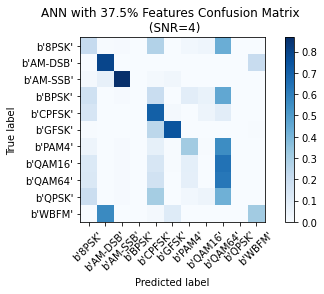

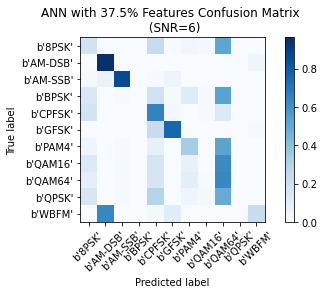

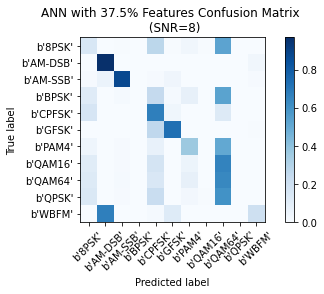

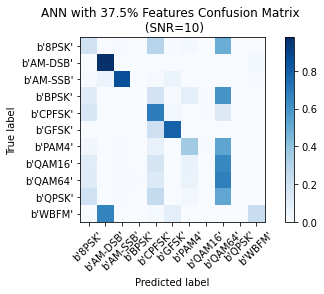

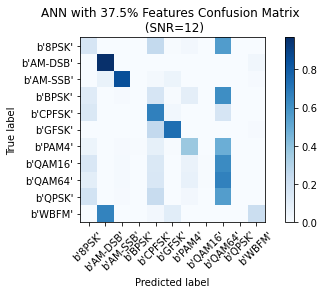

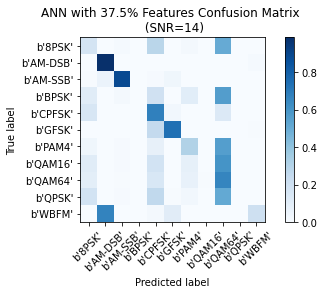

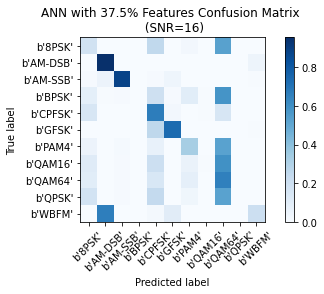

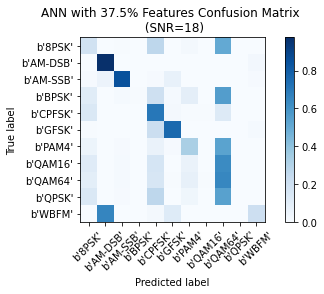

In [99]:
print('Confusion matrix of ANN with 37.5% features for different SNRs')
acc_2 = getTestAccArray(model_2, lbl, X_test_2, y_test, test_idx, 'ANN with 37.5% Features')

Confusion matrix of ANN with 50% features for different SNRs
Overall Accuracy:  0.09554597701149425 for SNR b'-20'
Overall Accuracy:  0.09600292024091987 for SNR b'-18'
Overall Accuracy:  0.10656328885683375 for SNR b'-16'
Overall Accuracy:  0.1119239209948793 for SNR b'-14'
Overall Accuracy:  0.1551385165326184 for SNR b'-12'
Overall Accuracy:  0.18962663233400773 for SNR b'-10'
Overall Accuracy:  0.24352810650887574 for SNR b'-8'
Overall Accuracy:  0.28887264754248126 for SNR b'-6'
Overall Accuracy:  0.33542488347077803 for SNR b'-4'
Overall Accuracy:  0.3416848220769789 for SNR b'-2'
Overall Accuracy:  0.37045203969129 for SNR b'0'
Overall Accuracy:  0.37463715529753266 for SNR b'2'
Overall Accuracy:  0.3665141811527905 for SNR b'4'
Overall Accuracy:  0.384883507613282 for SNR b'6'
Overall Accuracy:  0.37953973390866597 for SNR b'8'
Overall Accuracy:  0.3865456486919381 for SNR b'10'
Overall Accuracy:  0.3866739486619334 for SNR b'12'
Overall Accuracy:  0.3905368516833485 for SNR b'

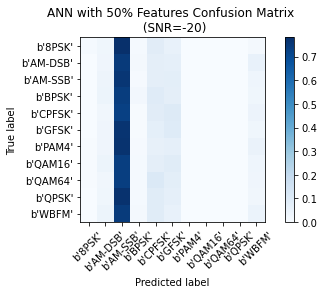

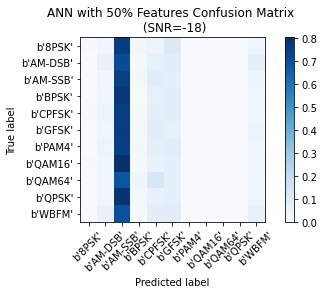

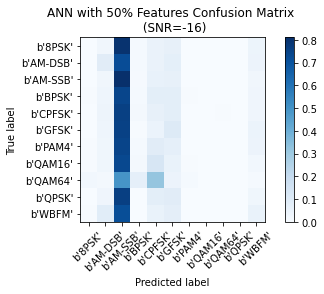

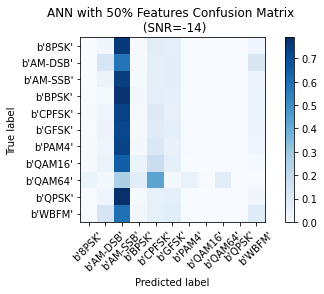

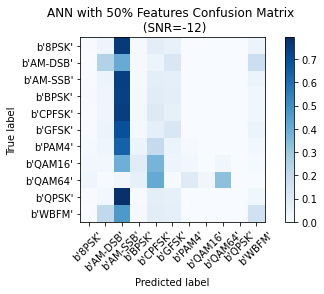

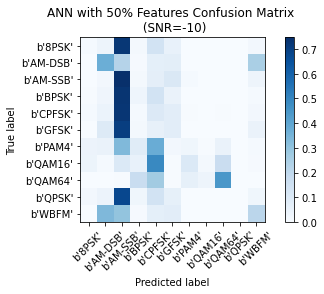

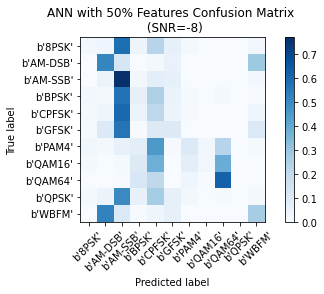

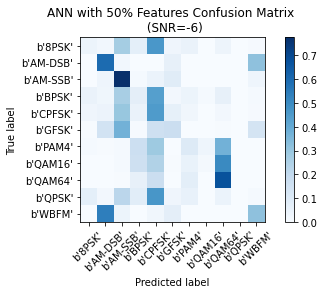

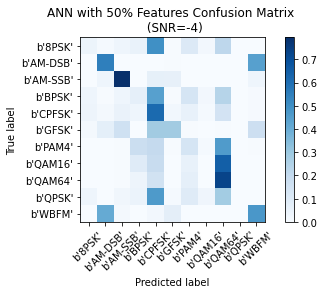

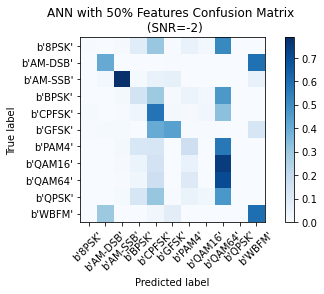

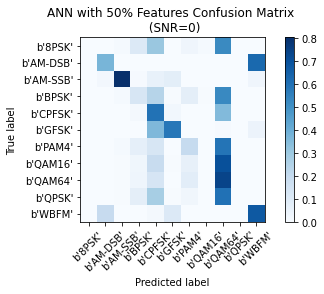

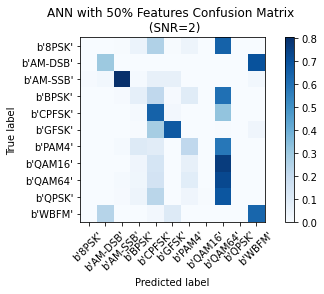

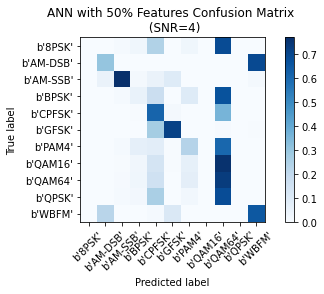

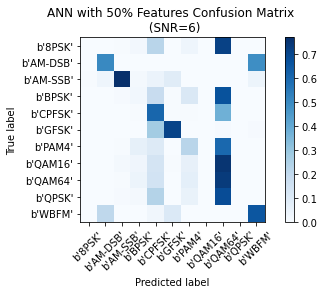

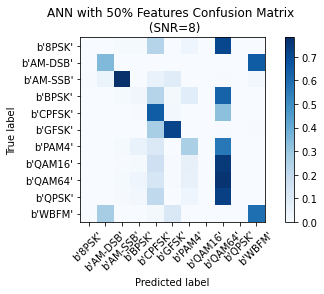

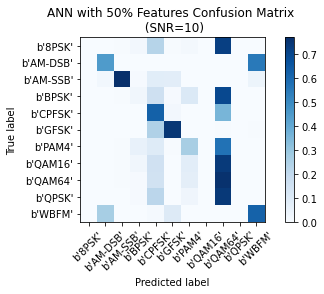

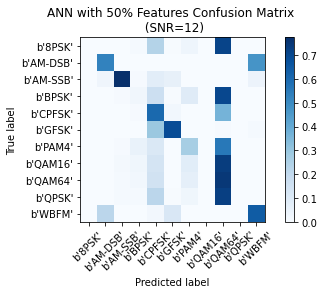

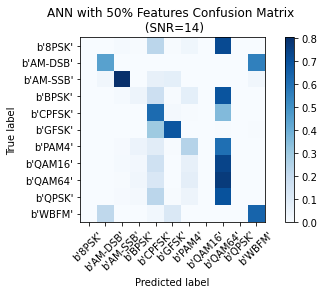

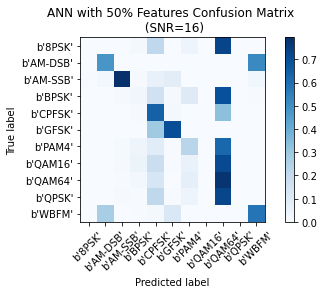

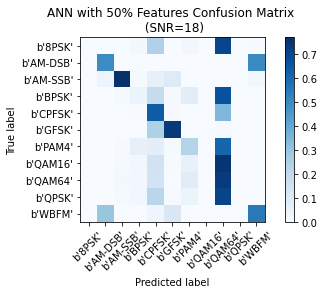

In [100]:
print('Confusion matrix of ANN with 50% features for different SNRs')
acc_3 = getTestAccArray(model_3, lbl, X_test_3, y_test, test_idx, 'ANN with 50% Features')

Confusion matrix of ANN with 75% features for different SNRs
Overall Accuracy:  0.09482758620689655 for SNR b'-20'
Overall Accuracy:  0.09636795035590436 for SNR b'-18'
Overall Accuracy:  0.1013342949873783 for SNR b'-16'
Overall Accuracy:  0.11722750548646671 for SNR b'-14'
Overall Accuracy:  0.1447721179624665 for SNR b'-12'
Overall Accuracy:  0.19312120654772852 for SNR b'-10'
Overall Accuracy:  0.2540680473372781 for SNR b'-8'
Overall Accuracy:  0.3296181253425909 for SNR b'-6'
Overall Accuracy:  0.3594478307637146 for SNR b'-4'
Overall Accuracy:  0.39469862018881624 for SNR b'-2'
Overall Accuracy:  0.4310915104740904 for SNR b'0'
Overall Accuracy:  0.44720609579100146 for SNR b'2'
Overall Accuracy:  0.4294602012808783 for SNR b'4'
Overall Accuracy:  0.4424876169510182 for SNR b'6'
Overall Accuracy:  0.4275440489032722 for SNR b'8'
Overall Accuracy:  0.4458088627869728 for SNR b'10'
Overall Accuracy:  0.4451119606772256 for SNR b'12'
Overall Accuracy:  0.44986351228389443 for SNR b

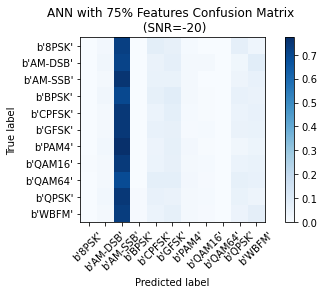

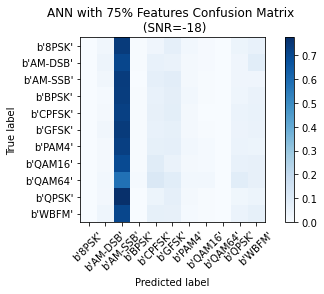

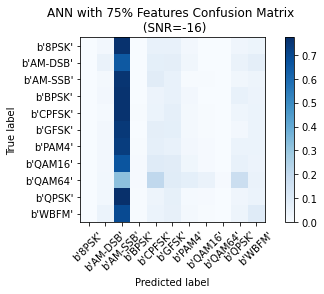

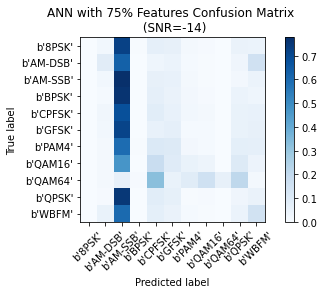

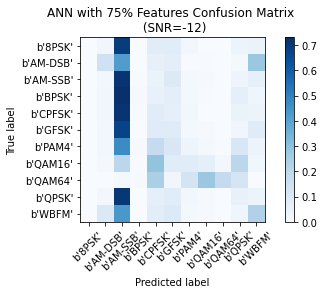

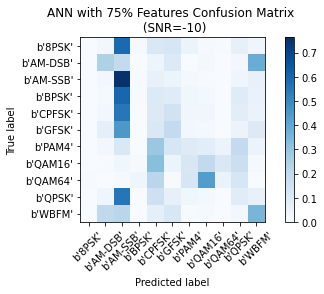

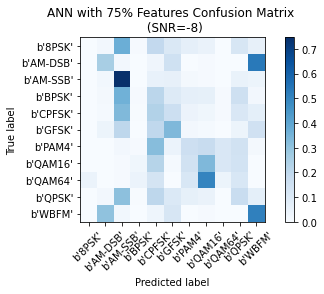

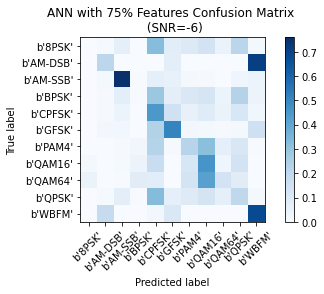

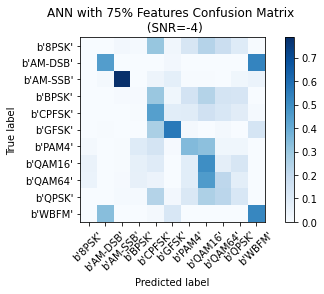

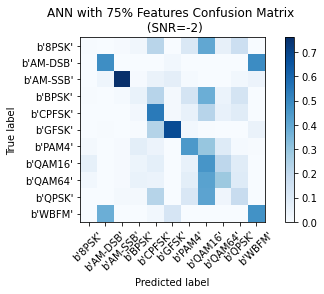

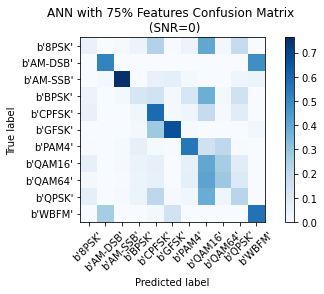

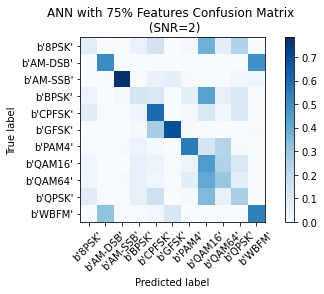

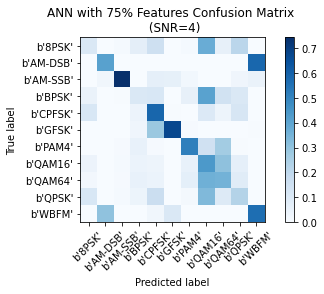

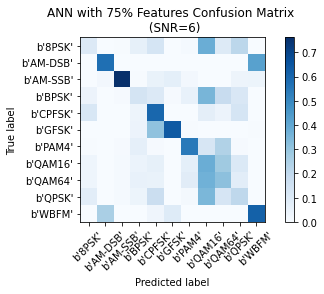

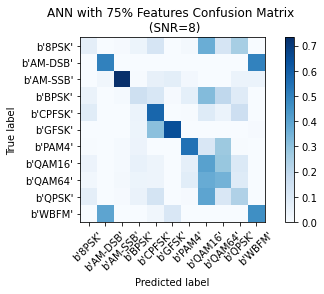

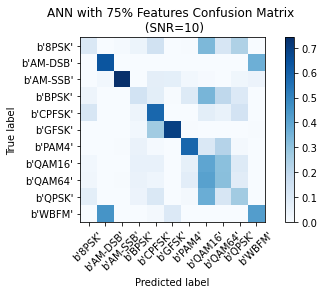

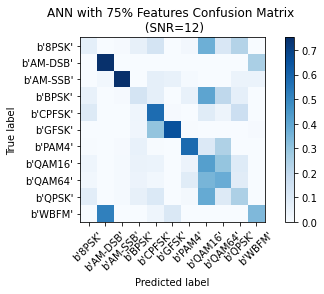

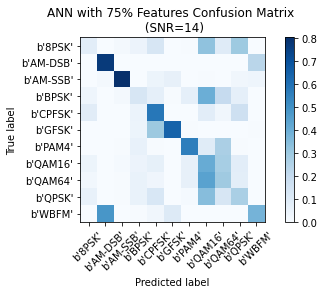

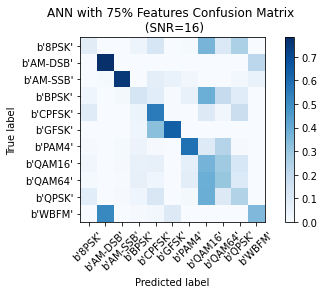

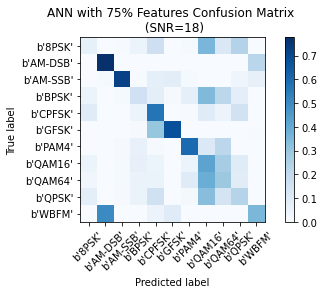

In [101]:
print('Confusion matrix of ANN with 75% features for different SNRs')
acc_4 = getTestAccArray(model_4, lbl, X_test_4, y_test, test_idx, 'ANN with 75% Features')

Confusion matrix of ANN with all features for different SNRs
Overall Accuracy:  0.09213362068965517 for SNR b'-20'
Overall Accuracy:  0.09837561598831904 for SNR b'-18'
Overall Accuracy:  0.10890732059141724 for SNR b'-16'
Overall Accuracy:  0.13917337234820776 for SNR b'-14'
Overall Accuracy:  0.17247542448614836 for SNR b'-12'
Overall Accuracy:  0.21390472687143644 for SNR b'-10'
Overall Accuracy:  0.28513313609467456 for SNR b'-8'
Overall Accuracy:  0.3394847432852183 for SNR b'-6'
Overall Accuracy:  0.4044460380064539 for SNR b'-4'
Overall Accuracy:  0.5557371096586783 for SNR b'-2'
Overall Accuracy:  0.6598676957001103 for SNR b'0'
Overall Accuracy:  0.673621190130624 for SNR b'2'
Overall Accuracy:  0.6631290027447393 for SNR b'4'
Overall Accuracy:  0.6609796367638965 for SNR b'6'
Overall Accuracy:  0.6565983459187342 for SNR b'8'
Overall Accuracy:  0.6534970635344367 for SNR b'10'
Overall Accuracy:  0.6451847806298926 for SNR b'12'
Overall Accuracy:  0.6585987261146496 for SNR b'

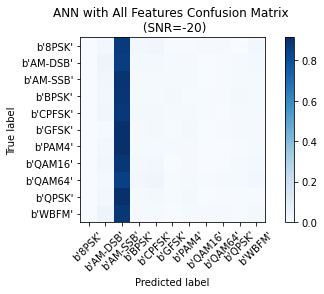

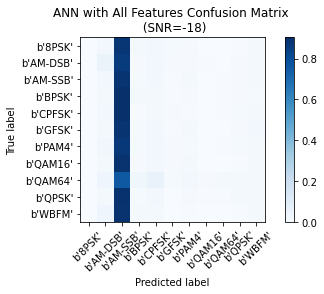

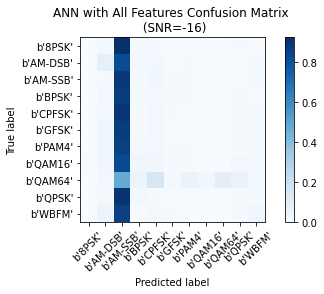

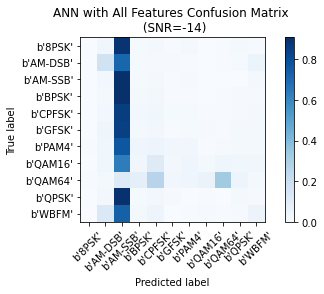

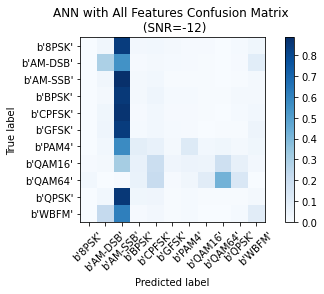

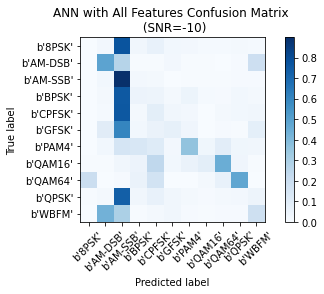

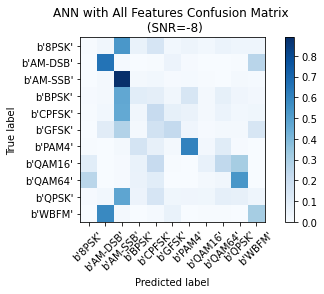

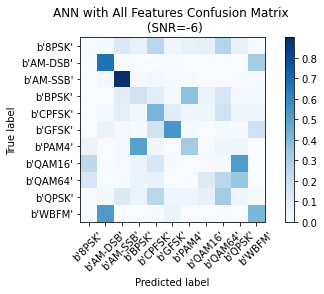

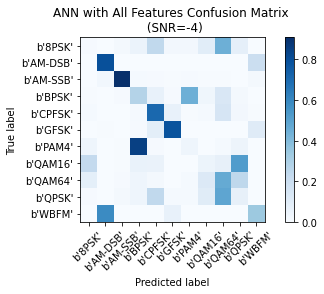

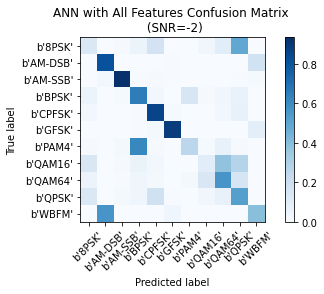

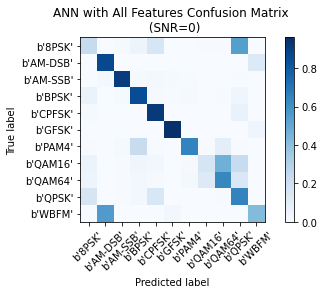

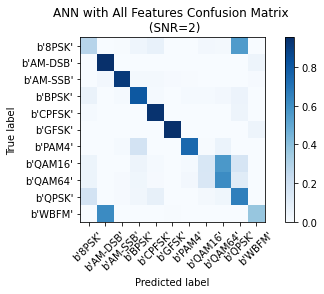

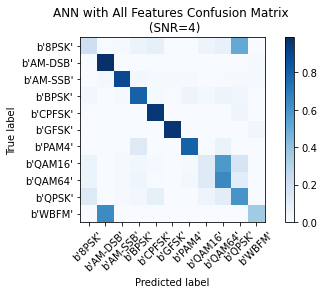

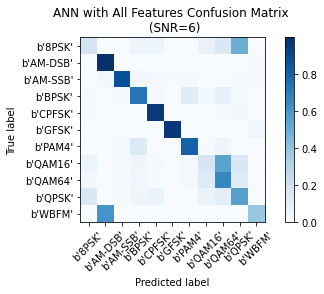

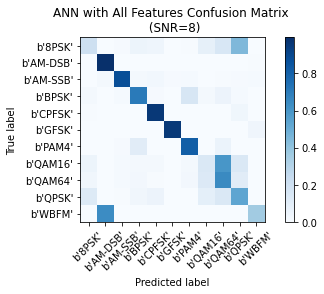

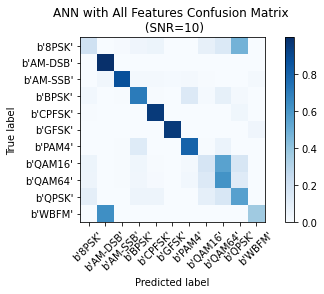

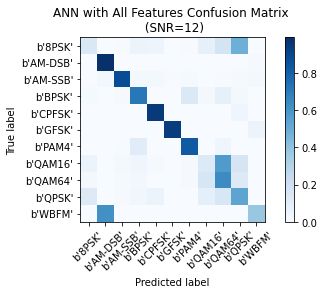

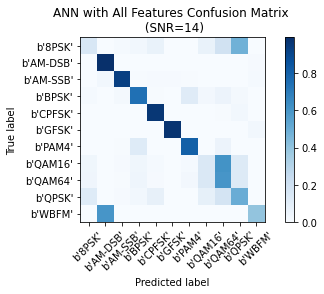

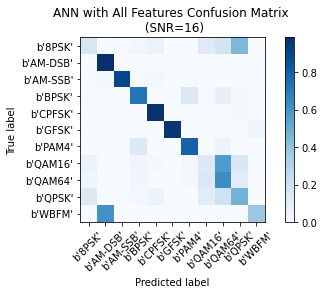

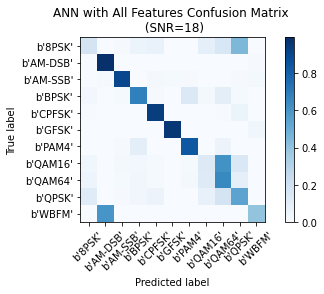

In [102]:
print('Confusion matrix of ANN with all features for different SNRs')
acc_5 = getTestAccArray(model_5, lbl, X_test, y_test, test_idx, 'ANN with All Features')

## Plot accuracy curves

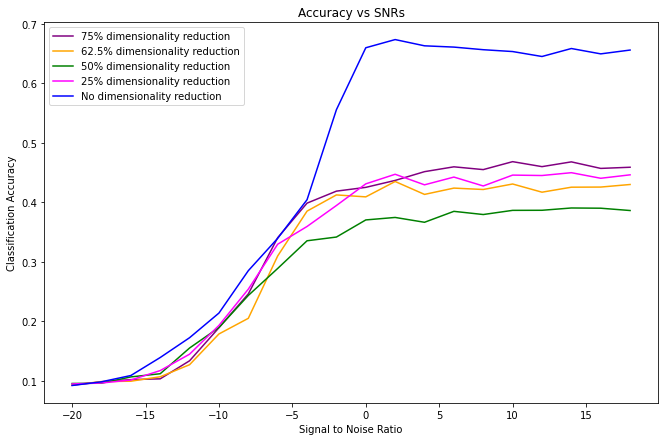

In [103]:
plt.figure(figsize = (11, 7))
plt.plot(snrs, acc_1, color= 'purple', label= '75% dimensionality reduction')
plt.plot(snrs, acc_2, color= 'orange', label= '62.5% dimensionality reduction')
plt.plot(snrs, acc_3, color= 'green', label= '50% dimensionality reduction')
plt.plot(snrs, acc_4, color= 'magenta', label= '25% dimensionality reduction')
plt.plot(snrs, acc_5, color= 'blue', label= 'No dimensionality reduction')
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title('Accuracy vs SNRs')
plt.legend()
plt.savefig('img/ANN_using_PCA_result.png')
plt.show()